In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%matplotlib inline

In [6]:
def process_datetime_columns(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

In [7]:
trip_counts_by_day = {day: 0 for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}

In [8]:
def calculate_trip_duration(df):
    df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.0
    return df

In [13]:
chunk_size = 10000
for chunk in pd.read_csv('../raw_data/merged_data.csv', chunksize=chunk_size):
    chunk = process_datetime_columns(chunk)
    chunk = calculate_trip_duration(chunk)

    day_counts = chunk['pickup_day_of_week'].value_counts()
    for day, count in day_counts.items():
        trip_counts_by_day[day] += count

/tmp/ipykernel_111336/2989761700.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
/tmp/ipykernel_111336/2989761700.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
/tmp/ipykernel_111336/2989761700.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
/tmp/ipykernel_111336/2989761700.py:2: UserWarning: Could not infer format, so each elem

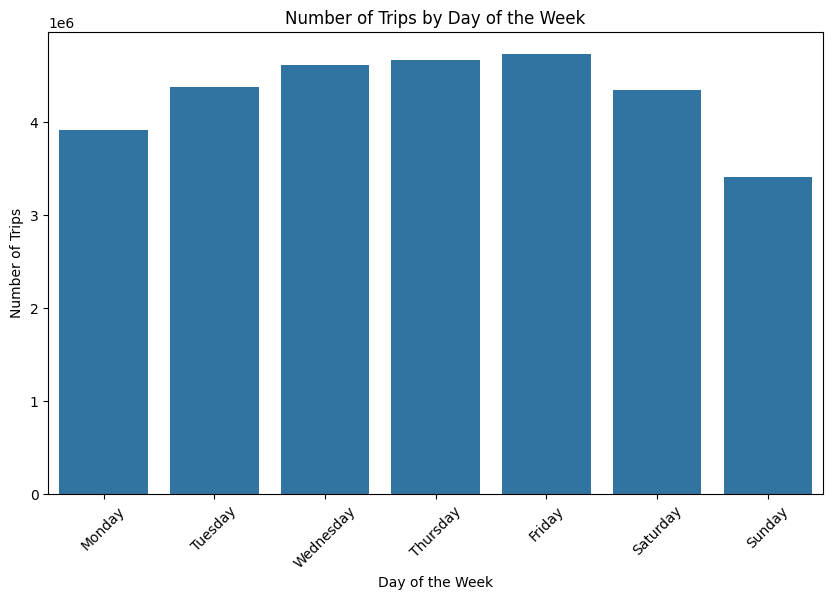

In [15]:
days = list(trip_counts_by_day.keys())
counts = list(trip_counts_by_day.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=days, y=counts)
plt.title('Number of Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()


In [9]:
total_duration_by_hour = np.zeros(24)
trip_counts_by_hour = np.zeros(24)

trip_distances = []

pickup_latitudes = []
pickup_longitudes = []

aggregated_data = pd.DataFrame()

daily_trip_counts = defaultdict(int)
daily_precipitation = {}

In [11]:
chunk_size = 10000

for chunk in pd.read_csv('../raw_data/merged_data.csv', chunksize=chunk_size, parse_dates=['pickup_datetime', 'dropoff_datetime']):
    # Calculate trip duration in minutes
    chunk['trip_duration'] = (chunk['dropoff_datetime'] - chunk['pickup_datetime']).dt.total_seconds() / 60.0

    # Extract the pickup hour
    chunk['pickup_hour'] = chunk['pickup_datetime'].dt.hour

    # Update total duration and trip counts by hour
    hourly_duration = chunk.groupby('pickup_hour')['trip_duration'].sum()
    hourly_counts = chunk['pickup_hour'].value_counts()
    for hour in range(24):
        total_duration_by_hour[hour] += hourly_duration.get(hour, 0)
        trip_counts_by_hour[hour] += hourly_counts.get(hour, 0)

    # Append trip distances for distribution analysis
    trip_distances.extend(chunk['trip_distance'].values)

    # Append pickup coordinates for heatmap
    pickup_latitudes.extend(chunk['pickup_latitude'].values)
    pickup_longitudes.extend(chunk['pickup_longitude'].values)

    # Append relevant columns for correlation analysis
    aggregated_data = pd.concat([aggregated_data, chunk[['trip_distance', 'fare_amount', 'tavg', 'prcp']]], ignore_index=True)

    # Update daily trip counts and precipitation for weather impact analysis
    chunk['pickup_date'] = chunk['pickup_datetime'].dt.date
    daily_counts = chunk['pickup_date'].value_counts()
    for date, count in daily_counts.items():
        daily_trip_counts[date] += count
    daily_precip = chunk.groupby('pickup_date')['prcp'].first()
    for date, prcp in daily_precip.items():
        daily_precipitation[date] = prcp


/tmp/ipykernel_122644/4188541130.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  for chunk in pd.read_csv('../raw_data/merged_data.csv', chunksize=chunk_size, parse_dates=['pickup_datetime', 'dropoff_datetime']):


KeyError: 'pickup_latitude'

In [ ]:
with np.errstate(divide='ignore', invalid='ignore'):
    average_duration_by_hour = np.where(trip_counts_by_hour != 0, total_duration_by_hour / trip_counts_by_hour, 0)

# Plot
hours = range(24)
plt.figure(figsize=(12, 6))
sns.barplot(x=hours, y=average_duration_by_hour, palette='viridis')
plt.title('Average Trip Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Duration (minutes)')
plt.xticks(hours)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(trip_distances, bins=50, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.kdeplot(x=pickup_longitudes, y=pickup_latitudes, cmap='viridis', shade=True, bw_adjust=0.5)
plt.title('Heatmap of Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
correlation_matrix = aggregated_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [ ]:
# Distribution of Trip Durations
plt.figure(figsize=(10, 6))
sns.histplot(trip_durations, bins=50, kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

# Trip Duration vs. Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=trip_distances, y=trip_durations, alpha=0.5)
plt.title('Trip Duration vs. Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Trip Duration (minutes)')
plt.show()


In [ ]:
# Payment Method Distribution
payment_types = df['payment_type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=payment_types.index, y=payment_types.values, palette='viridis')
plt.title('Distribution of Payment Methods')
plt.xlabel('Payment Type')
plt.ylabel('Number of Trips')
plt.show()

# Tip Amount by Payment Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_type', y='tip_amount', data=df)
plt.title('Tip Amount by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Tip Amount ($)')
plt.show()

In [ ]:
# Revenue by Day of Week
df['day_of_week'] = df['lpep_pickup_datetime'].dt.day_name()
revenue_by_day = df.groupby('day_of_week')['total_amount'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_by_day.index, y=revenue_by_day.values, palette='viridis')
plt.title('Total Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue ($)')
plt.show()

# Revenue Heatmap by Hour and Day
df['hour_of_day'] = df['lpep_pickup_datetime'].dt.hour
revenue_heatmap = df.pivot_table(index='hour_of_day', columns='day_of_week', values='total_amount', aggfunc='sum').reindex(
    columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.figure(figsize=(12, 8))
sns.heatmap(revenue_heatmap, cmap='viridis', annot=True, fmt='.0f')
plt.title('Revenue Heatmap by Hour and Day')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()


In [ ]:
# Trips by Passenger Count
passenger_counts = df['passenger_count'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=passenger_counts.index, y=passenger_counts.values, palette='viridis')
plt.title('Number of Trips by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.show()

# Fare Amount vs. Passenger Count
plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title('Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.show()


In [ ]:
# Calculate Average Speed (miles per hour)
df['trip_duration_hours'] = df['trip_duration'] / 60  # Convert duration to hours
df['average_speed'] = df['trip_distance'] / df['trip_duration_hours']

# Distribution of Average Speeds
plt.figure(figsize=(10, 6))
sns.histplot(df['average_speed'].dropna(), bins=50, kde=True)
plt.title('Distribution of Average Trip Speeds')
plt.xlabel('Average Speed (mph)')
plt.ylabel('Frequency')
plt.show()

# Average Speed by Hour of Day
average_speed_by_hour = df.groupby('hour_of_day')['average_speed'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=average_speed_by_hour.index, y=average_speed_by_hour.values)
plt.title('Average Trip Speed by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (mph)')
plt.xticks(range(24))
plt.show()


In [ ]:
# Common Routes
common_routes = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='trip_count')
common_routes = common_routes.sort_values(by='trip_count', ascending=False).head(10)

# Visualize Common Routes
plt.figure(figsize=(10, 6))
sns.barplot(x=common_routes['trip_count'], y=common_routes.index, palette='viridis')
plt.title('Top 10 Most Frequent Routes')
plt.xlabel('Number of Trips')
plt.ylabel('Route (PU Location ID -> DO Location ID)')
plt.show()

# Average Duration for Common Routes
common_routes_duration


In [ ]:
# Prepare data
dates = sorted(daily_trip_counts.keys())
trip_counts = [daily_trip_counts[date] for date in dates]
precipitation = [daily_precipitation.get(date, 0) for date in dates]

# Create DataFrame
weather_trip_data = pd.DataFrame({
    'Date': dates,
    'Trip_Counts': trip_counts,
    'Precipitation': precipitation
})

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
sns.lineplot(data=weather_trip_data, x='Date', y='Trip_Counts', ax=ax1, label='Trip Counts', color='b')
sns.lineplot(data=weather_trip_data, x='Date', y='Precipitation', ax=ax2, label='Precipitation', color='g')

ax1.set_xlabel('Date')
ax1.set_ylabel('Trip Counts', color='b')
ax2.set_ylabel('Precipitation (mm)', color='g')
plt.title('Impact of Weather on Trip Volume')
fig.tight_layout()
plt.show()
